In [2]:
import os
args = os.getenv("ARGS", "release real").split(" ")
release = args[0]
arch = args[1]

In [3]:
assert arch == "real"

In [4]:
try:
    import google.colab  # noqa: F401
except ImportError:
    import dolfin
    import ufl_legacy
else:
    try:
        import dolfin
        import ufl_legacy
    except ImportError:
        if release != "development":
            !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        else:
            !wget "https://fem-on-colab.github.io/releases/fenics-install-development-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
        import dolfin
        import ufl_legacy

--2025-03-18 13:01:25--  https://fem-on-colab.github.io/releases/fenics-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4180 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.08K  --.-KB/s    in 0s      

2025-03-18 13:01:26 (14.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [4180/4180]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f33a7ab/releases/pybi

In [26]:
import numpy as np
from fenics import*
from petsc4py import PETSc
assert not np.issubdtype(PETSc.ScalarType, np.complexfloating)

In [24]:
from pyomo.environ import*
from pyomo.dae import*
import numpy as np
from matplotlib import pyplot as plt
import pyomo.contrib.mpc as mpc
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.ticker as ticker
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [28]:
!pip install CoolProp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 39.1 MB/s eta 0:00:00


In [29]:
import CoolProp.CoolProp as CP

def calc_h_is(temp_array = None, P_s = None, T_s = None, ref_name = None, list_Pc=None, list_h_is=None):
    i = 0
    while (i < 24):

        s_i = CP.PropsSI('S', 'T', float(T_s) + 273.15, 'P', P_s, ref_name)
        P_c = CP.PropsSI('P', 'T', float(temp_array[i]) + 273.15, 'Q', 1, ref_name)
        h_is = CP.PropsSI('H', 'P', P_c, 'S', s_i, ref_name)
        list_Pc.append(P_c)
        list_h_is.append(h_is)
        i += 0.25
    return [list_Pc, list_h_is]

def calc_h_ic(temp_array = None, P_s = None, T_s = None, ref_name = None):

    h_ic = CP.PropsSI('H', 'P', P_s, 'T', float(T_s) + 273.15, ref_name)
    return h_ic

In [30]:
N = 96

# Generate sample data: temperature measurements over one day
start_time = dt.datetime(2025, 2, 21, 0, 0)

# Create times every 10 minutes over 24 hours
times = [start_time + dt.timedelta(minutes=15*i) for i in range(N)]

# Simulate temperature with a sine wave
# out_temp = 21 + 6*np.sin( np.linspace(-np.pi/2, 3*np.pi/2, len(times) ))

# Create a ConcreteModel
model = ConcreteModel()

# Create a time vector with 15-minute intervals over 24 hours.
time_points = np.arange(0, 24 , 0.25)
time_list = [round(t, 2) for t in time_points]

# Define the time set in the Pyomo model.
model.T = Set(initialize=time_list, ordered=True)

# Define the temperature rule as a piecewise function.
def temp_rule(model, t):
    if t < 6 or t >= 23:
        return 18.0
    elif 6 <= t < 14:
        return 18.0 + (27.0 - 18.0) * (t - 6) / (14 - 6)
    elif 14 <= t < 23:
        return 27.0 - (27.0 - 18.0) * (t - 14) / (23 - 14)

# Create a parameter for the outdoor temperature over the time set.
model.out_temp = Param(model.T, initialize=temp_rule)

out_temp = [model.out_temp[t] for t in model.T]

P_s = 2e5    # suction pressure
T_s = -10.5  # suction temperature in degree centigrades
ref_name = "R134a"

Pc = calc_h_is(model.out_temp, P_s, T_s, ref_name, [], [])[0]
h_is = calc_h_is(model.out_temp, P_s, T_s, ref_name, [], [])[1]
h_ic = calc_h_ic(model.out_temp, P_s, T_s, ref_name)

ethlpy_diff = []
for i in range(len(h_is)):
    delta = h_is[i] - h_ic
    ethlpy_diff.append(delta)

Temp_precool = 4.0
Temp_storage = 12

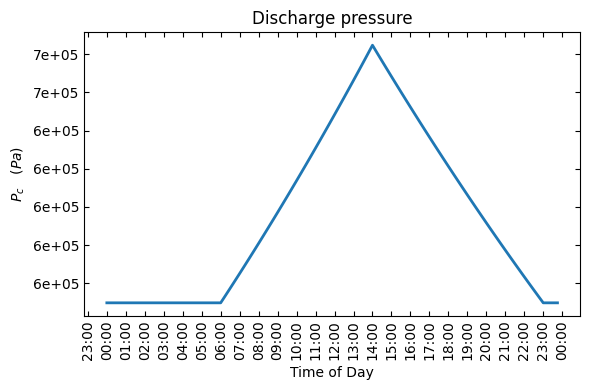

In [31]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(times, Pc, linestyle='-', lw=2)

# Set the y-axis to use scientific notation
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.0e}'))
# ax.text(0, 1.1, r'$10^5$', transform=ax.transAxes, fontsize=14, verticalalignment='top')


# Set x-axis major locator to display a tick every 3 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
# Format the ticks to show hours and minutes (e.g., 03:00)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.tick_params(which='both', direction='in', top=True, right=True)
plt.xticks(rotation=90)

plt.xlabel("Time of Day")
plt.ylabel("$P_{c} \quad (Pa)$")
plt.title("Discharge pressure")

plt.tight_layout()
plt.show()

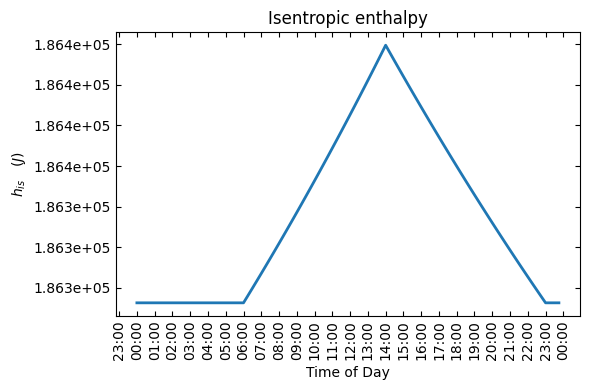

In [32]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(times, h_is, linestyle='-', lw=2)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.3e}'))

# Set x-axis major locator to display a tick every 3 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
# Format the ticks to show hours and minutes (e.g., 03:00)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.tick_params(which='both', direction='in', top=True, right=True)
plt.xticks(rotation=90)

plt.xlabel("Time of Day")
plt.ylabel("$h_{is} \quad (J)$")
plt.title("Isentropic enthalpy")

plt.tight_layout()
plt.show()

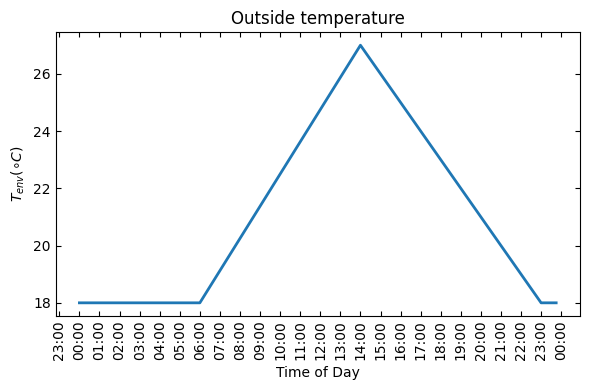

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(times, out_temp, linestyle='-', lw=2)

# Set x-axis major locator to display a tick every 3 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
# Format the ticks to show hours and minutes (e.g., 03:00)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.tick_params(which='both', direction='in', top=True, right=True)
plt.xticks(rotation=90)

plt.xlabel("Time of Day")
plt.ylabel("$T_{env} (\circ C)$")
plt.title("Outside temperature")

plt.tight_layout()
plt.show()

In [54]:
class Solve_Unsteady_CoupledPDE:

  def __init__(self, W):   # self allows to access the objects' attributes

    self.W = W

  def TrialAndTestFunction(self):

    u = TrialFunction(self.W)  # (T_a, T_s)
    u1, u2 = split(u)
    v = TestFunction(self.W)   # (v1, v2)
    v1, v2 = split(v)

    return np.array([u1, u2, v1, v2])

In [56]:
p0 = Point(0, 0)  # Lower left corner
p1 = Point(1.5, 0.6)  # Upper right corner

# Define the number of divisions along x and y directions
nx = 20  # divisions along the x-axis
ny = 10  # divisions along the y-axis

time_step = 600   ## in seconds

# Create a rectangular mesh over the defined domain
mesh = RectangleMesh(p0, p1, nx, ny)

P1 = FiniteElement("P", mesh.ufl_cell(), 1)  # Quadratic for T1
P2 = FiniteElement("P", mesh.ufl_cell(), 2)  # Linear for T2

# Create a mixed finite element and function space
element = MixedElement([P1, P2])
W = FunctionSpace(mesh, element)

##

lambda_f = 0.026
lambda_s = 0.610
cp_s = 4100
rho_s = 1013
cp_f = 1006
rho_f = 1.2
epsilon = 0.3
a_f = lambda_f/(rho_f*cp_f)
a_s = lambda_s/(rho_s*cp_s)
S_b = 84
h_sf = 17.01
gamma_1 = (S_b*h_sf)/(epsilon*rho_f*cp_f)
gamma_2 = (S_b*h_sf)/((1-epsilon)*rho_s*cp_s)

diff_f = Constant(a_f)
diff_s = Constant(a_s)
gamma_f = Constant(gamma_1)
gamma_s = Constant(gamma_2)
vel = Constant((0.0, 0.05))
k = Constant(time_step)


TrialAndTestFunctions = Solve_Unsteady_CoupledPDE(W)
u1 = TrialAndTestFunctions.TrialAndTestFunction()[0]
u2 = TrialAndTestFunctions.TrialAndTestFunction()[1]
v1 = TrialAndTestFunctions.TrialAndTestFunction()[2]
v2 = TrialAndTestFunctions.TrialAndTestFunction()[3]

# Initial conditions
u_0 = Constant((25.0, 25.0))
u_n = project(u_0, W)
u_n1, u_n2 = split(u_n)

def boundary(x, on_boundary):
    return on_boundary and near(x[1], 0.6)

F = ((u1 - u_n1)/k)*v1*dx + dot(vel, grad(u1))*v1*dx + 100*diff_f*inner( grad(u1), grad(v1) )*dx + gamma_f*u1*v1*dx \
 - gamma_f*u2*v1*dx + ((u2 - u_n2)/k)*v2*dx + 100*diff_s*inner( grad(u2), grad(v2) )*dx - gamma_s*u1*v2*dx \
 + gamma_s*u2*v2*dx

a = lhs(F)
L = rhs(F)

t = 0
u_sol = Function(W)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c9230bbf833317803293d49e69b1ca5d982e549a

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'Mixed<CG1(?,?), CG2(?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG2(?,?)>, Vector<2 x CG1(?,?)>, CG1(?
                             ,?), CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.020179 seconds.

INFO:FFC:Compiler st

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_978539c9c3f3f77adf7e25c8caedeff80147285f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00212288 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0092926 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_422b4e875f026edf9c764f5b71146ccf88220c9a

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00575805 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.020298 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f1a70d56a39911206cee04b24282ae66450a1a5e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_245]'
  Unique elements:           'Mixed<CG1(?,?), CG2(?,?)>, Vector<2 x R0(?,?)>, Vector
                             <2 x CG1(?,?)>'
  Unique sub elements:       'Mixed<CG1(?,?), CG2(?,?)>, Vector<2 x R0(?,?)>, Vector
                             <2 x CG1(?,?)>, CG1(?,?), CG2(?,?), R0(?,?

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_57b2d046702a951357e83418ce8e636842a8edc4

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00308084 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0139179 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4fe63847645198f4fe621846b110deff2200b6db

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00229573 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.011241 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

position is deprecated.  Please use at()  (deprecated in 6.1, will be
removed in (or after) 7.0)
(called from <ipython-input-57-4c96be573974>:78)


At mpc_iteration  0.0
Objective value is:  703.3496798044237
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7f0660b086b3d8a1abd4300a2b55eb3d754cde5f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_244, f_252]'
  Unique elements:           'Mixed<CG1(?,?), CG2(?,?)>, R0(?,?), Vector<2 x CG1(?,?
                             )>'
  Unique sub elements:       'Mixed<CG1(?,?), CG2(?,?)>, R0(?,?), Vector<2 x CG1(?,?
                             )>, CG1(?,?), CG2(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:F

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00240183 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00934672 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representat

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00333452 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0177712 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00248432 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0076797 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7a7b6bbfb8ac4624ea425fedfc8e7c0614f261f7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    6
  Coefficients:     

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0bb6ea8295a9d49109447a98e18601bb13d2b05f

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00235343 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0108318 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

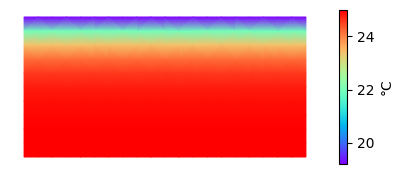

At mpc_iteration  0.25
Objective value is:  614.2159940660168


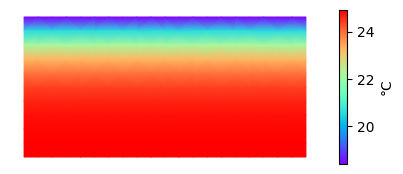

At mpc_iteration  0.5
Objective value is:  531.3670391380862


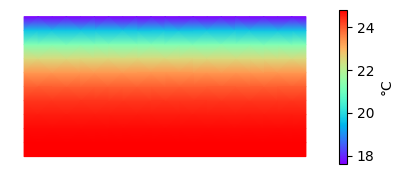

At mpc_iteration  0.75
Objective value is:  454.80281502061644


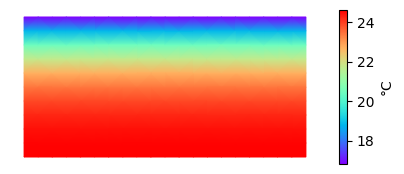

At mpc_iteration  1.0
Objective value is:  384.5233217135911


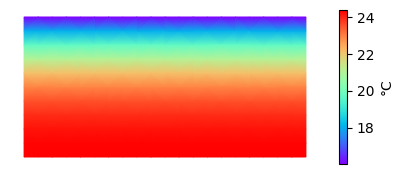

At mpc_iteration  1.25
Objective value is:  320.5285592169901


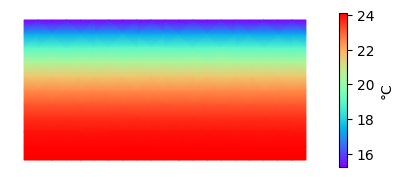

At mpc_iteration  1.5
Objective value is:  262.81852753078954


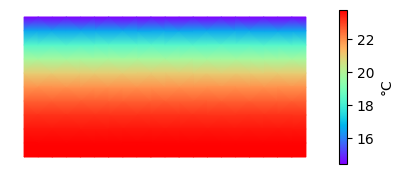

At mpc_iteration  1.75
Objective value is:  211.39322665496002


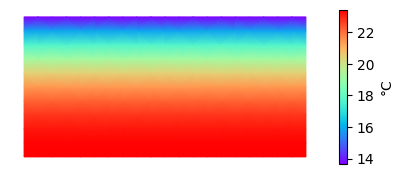

At mpc_iteration  2.0
Objective value is:  166.25265658946554


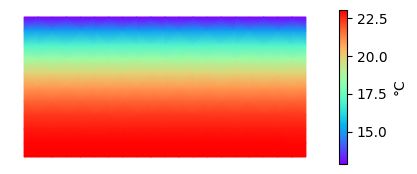

At mpc_iteration  2.25
Objective value is:  127.39681733426802


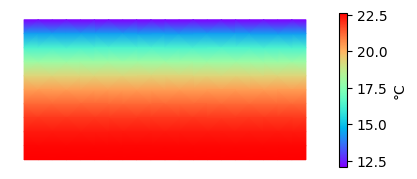

At mpc_iteration  2.5
Objective value is:  94.82570888955784


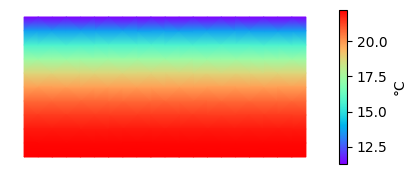

At mpc_iteration  2.75
Objective value is:  68.3293651469719


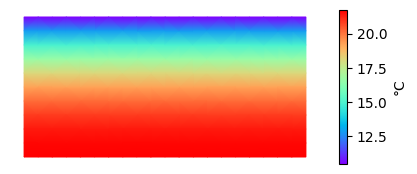

At mpc_iteration  3.0
Objective value is:  47.28978802156124


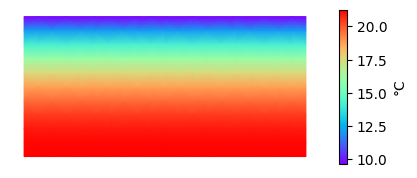

At mpc_iteration  3.25
Objective value is:  31.078504457776774


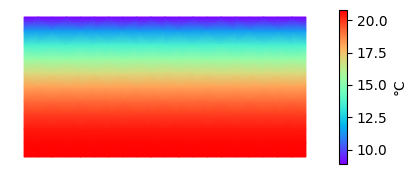

At mpc_iteration  3.5
Objective value is:  19.06704137376964


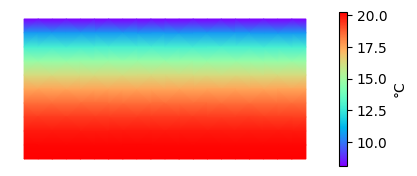

At mpc_iteration  3.75
Objective value is:  10.62692564683954


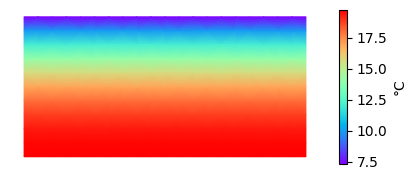

At mpc_iteration  4.0
Objective value is:  5.129684253640357


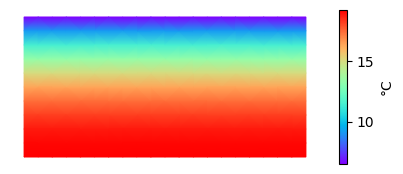

At mpc_iteration  4.25
Objective value is:  1.946844067000994


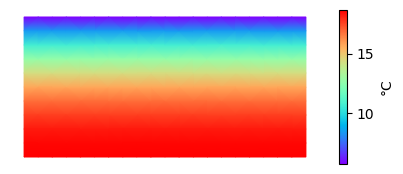

At mpc_iteration  4.5
Objective value is:  0.449932007748879


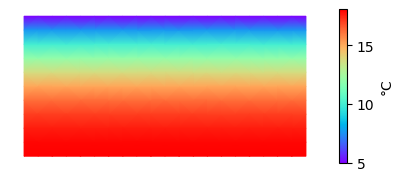

At mpc_iteration  4.75
Objective value is:  0.0104750371597034


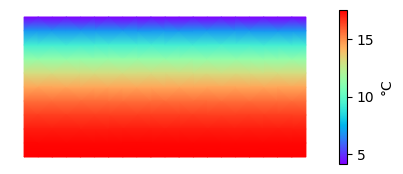

At mpc_iteration  5.0
Objective value is:  3.262182551452384e-08


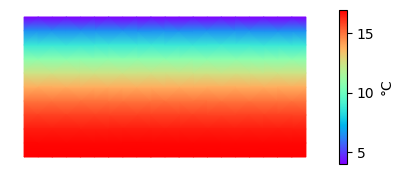

At mpc_iteration  5.25
Objective value is:  5.554066898821671e-09


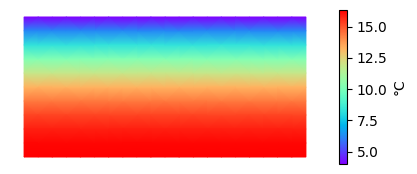

At mpc_iteration  5.5
Objective value is:  9.448343799282758e-09


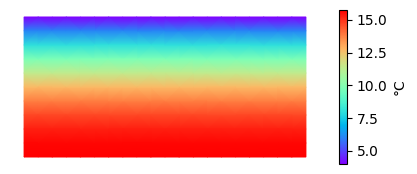

At mpc_iteration  5.75
Objective value is:  1.0019880764727018e-08


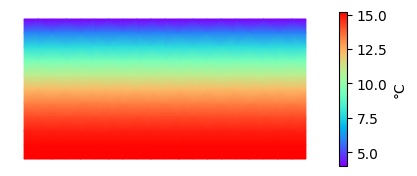

At mpc_iteration  6.0
Objective value is:  1.1098164121163948e-08


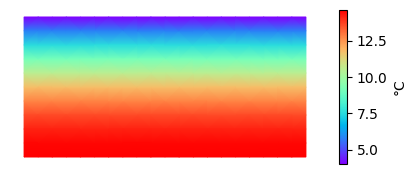

At mpc_iteration  6.25
Objective value is:  1.2537199110229323e-08


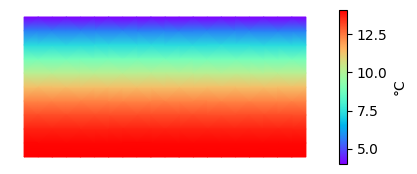

At mpc_iteration  6.5
Objective value is:  1.4240255739595152e-08


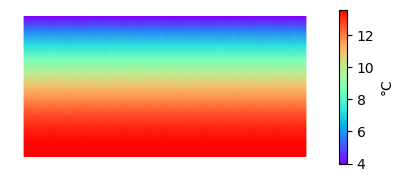

At mpc_iteration  6.75
Objective value is:  1.6143946369990326e-08


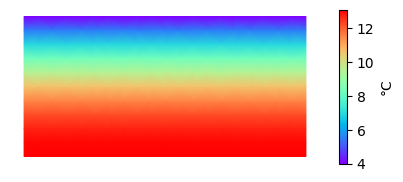

At mpc_iteration  7.0
Objective value is:  1.8203588614890197e-08


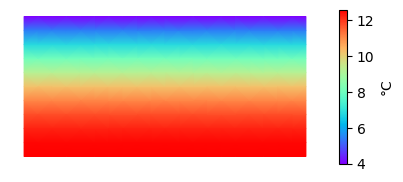

At mpc_iteration  7.25
Objective value is:  2.0386700783331583e-08


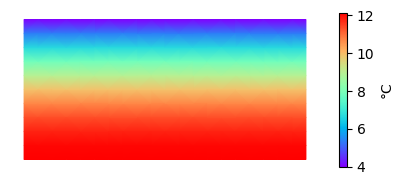

At mpc_iteration  7.5
Objective value is:  2.2669072822151228e-08


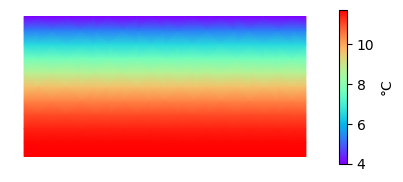

At mpc_iteration  7.75
Objective value is:  2.5032281495879407e-08


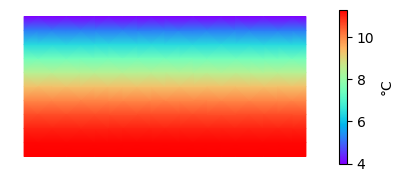

At mpc_iteration  8.0
Objective value is:  2.7462058837904394e-08


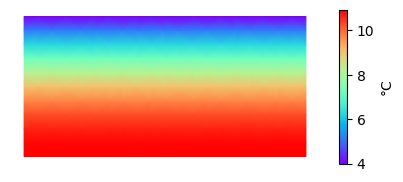

At mpc_iteration  8.25
Objective value is:  2.994718681351404e-08


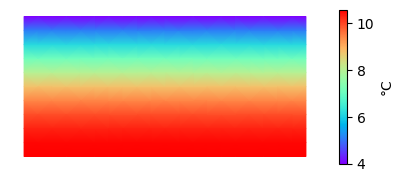

At mpc_iteration  8.5
Objective value is:  3.2478728361348916e-08


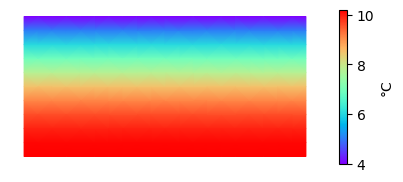

At mpc_iteration  8.75
Objective value is:  3.504948012579976e-08


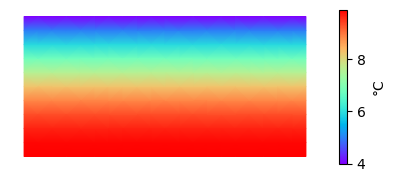

At mpc_iteration  9.0
Objective value is:  3.765357519055435e-08


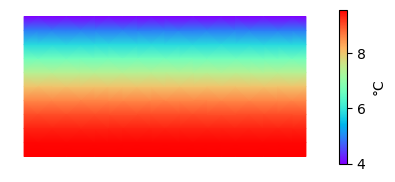

At mpc_iteration  9.25
Objective value is:  4.028618965462433e-08


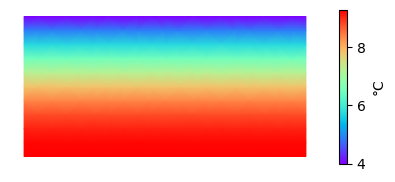

At mpc_iteration  9.5
Objective value is:  4.294332256387309e-08


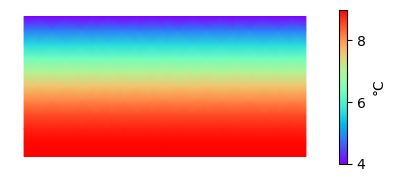

At mpc_iteration  9.75
Objective value is:  4.562162858728711e-08


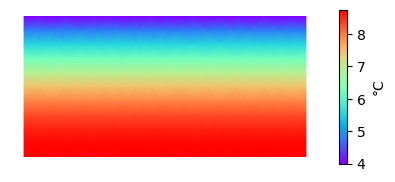

At mpc_iteration  10.0
Objective value is:  4.831828923768037e-08


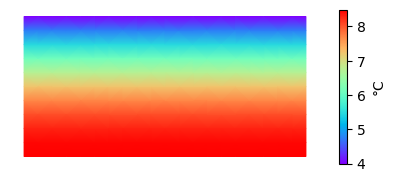

At mpc_iteration  10.25
Objective value is:  5.1030912658992964e-08


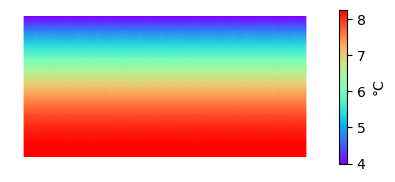

At mpc_iteration  10.5
Objective value is:  5.375745486590087e-08


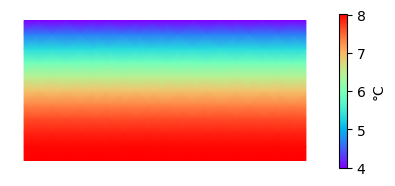

At mpc_iteration  10.75
Objective value is:  5.649615728108621e-08


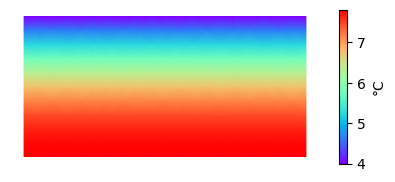

At mpc_iteration  11.0
Objective value is:  5.924549679094814e-08


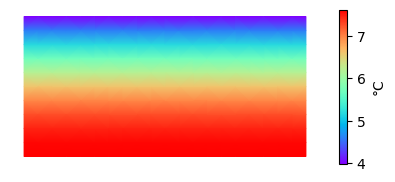

At mpc_iteration  11.25
Objective value is:  6.200414551049978e-08


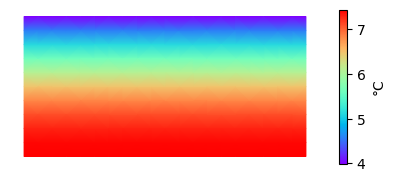

At mpc_iteration  11.5
Objective value is:  6.477093814538123e-08


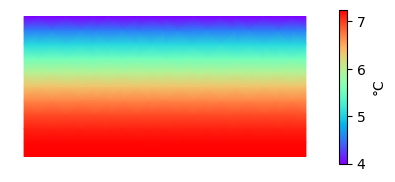

At mpc_iteration  11.75
Objective value is:  6.754484535487272e-08


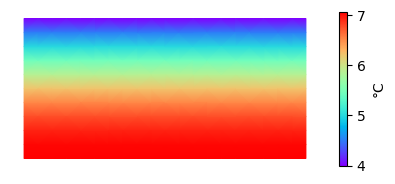

At mpc_iteration  12.0
Objective value is:  7.031052799247788e-08


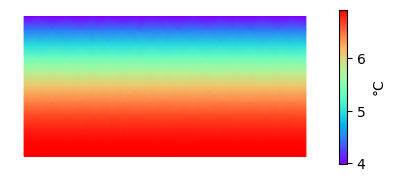

At mpc_iteration  12.25
Objective value is:  7.305670515817899e-08


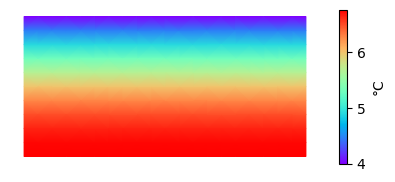

At mpc_iteration  12.5
Objective value is:  7.577475043275097e-08


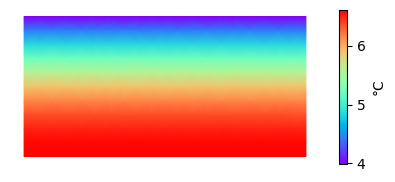

At mpc_iteration  12.75
Objective value is:  7.845824389783659e-08


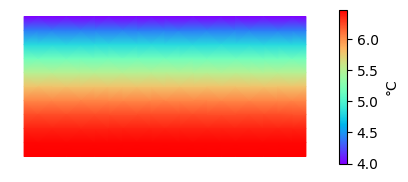

At mpc_iteration  13.0
Objective value is:  8.110245624535714e-08


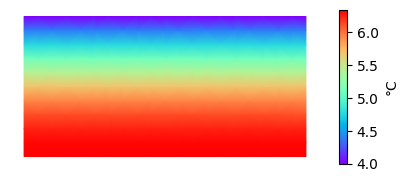

At mpc_iteration  13.25
Objective value is:  8.370388404353483e-08


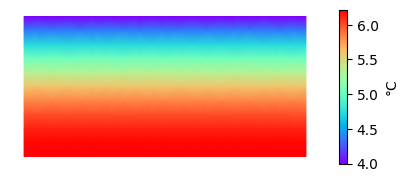

At mpc_iteration  13.5
Objective value is:  8.625985556407018e-08


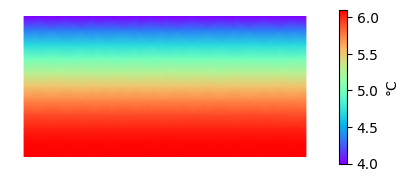

At mpc_iteration  13.75
Objective value is:  8.876820602353814e-08


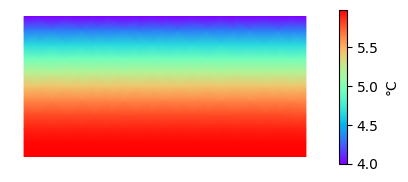

At mpc_iteration  14.0
Objective value is:  9.122701542772321e-08


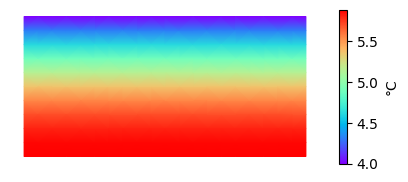

At mpc_iteration  14.25
Objective value is:  9.363441077943053e-08


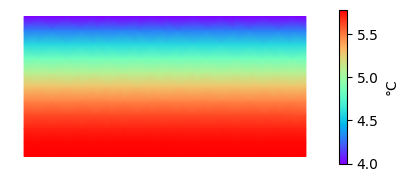

At mpc_iteration  14.5
Objective value is:  9.600812585193057e-08


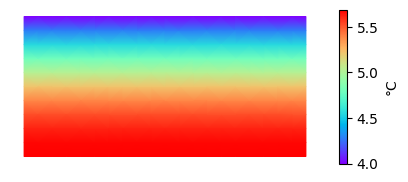

At mpc_iteration  14.75
Objective value is:  9.83485004301571e-08


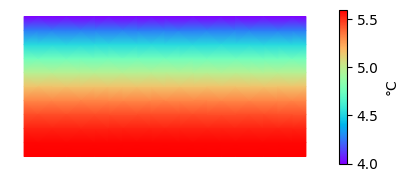

At mpc_iteration  15.0
Objective value is:  1.0065591125563792e-07


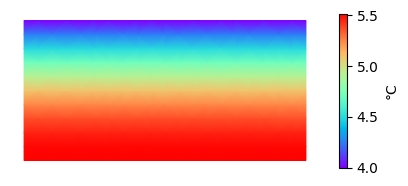

At mpc_iteration  15.25
Objective value is:  1.0293076611790093e-07


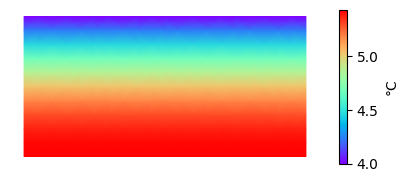

At mpc_iteration  15.5
Objective value is:  1.0517349883563683e-07


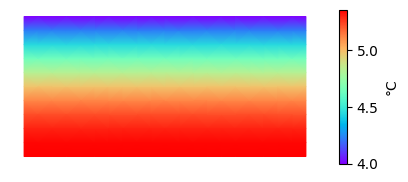

At mpc_iteration  15.75
Objective value is:  1.0738456497065899e-07


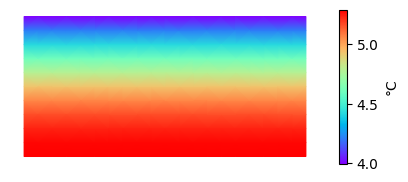

At mpc_iteration  16.0
Objective value is:  1.0956443817131743e-07


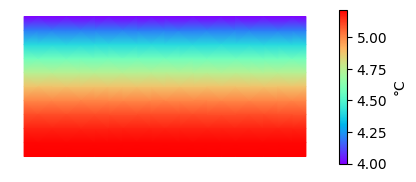

At mpc_iteration  16.25
Objective value is:  1.1171360702956592e-07


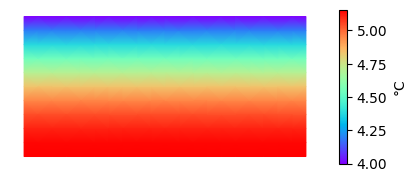

At mpc_iteration  16.5
Objective value is:  1.1383257238027296e-07


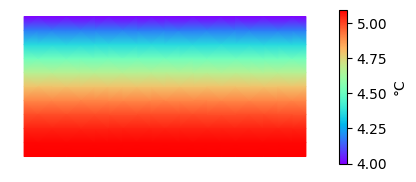

At mpc_iteration  16.75
Objective value is:  1.15921844976141e-07


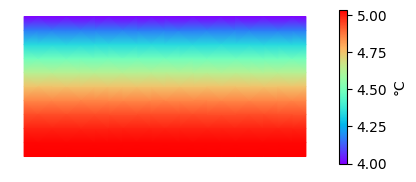

At mpc_iteration  17.0
Objective value is:  1.1798194347035923e-07


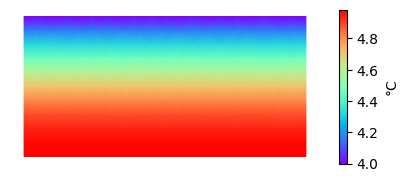

At mpc_iteration  17.25
Objective value is:  1.200133926734564e-07


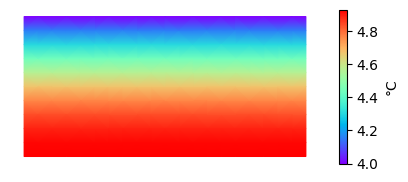

At mpc_iteration  17.5
Objective value is:  1.2201672203151542e-07


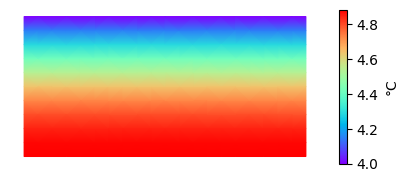

At mpc_iteration  17.75
Objective value is:  1.23992464305071e-07


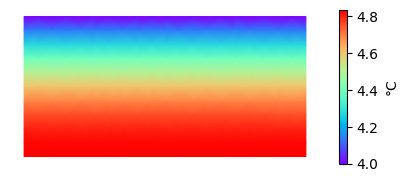

At mpc_iteration  18.0
Objective value is:  1.2594115440753003e-07


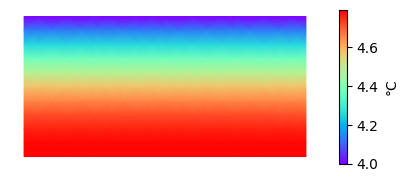

At mpc_iteration  18.25
Objective value is:  1.2786332838530958e-07


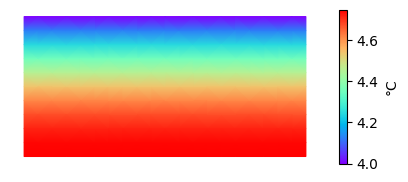

At mpc_iteration  18.5
Objective value is:  1.2975952252918273e-07


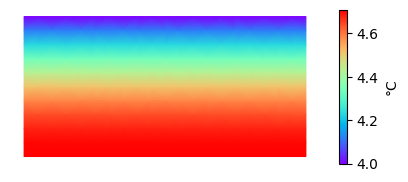

At mpc_iteration  18.75
Objective value is:  1.3163027257463348e-07


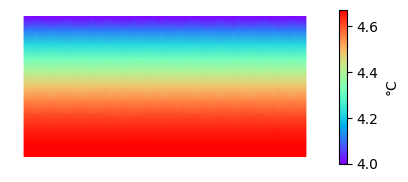

At mpc_iteration  19.0
Objective value is:  1.3347611300632563e-07


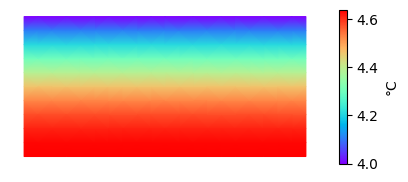

At mpc_iteration  19.25
Objective value is:  1.3529757643177128e-07


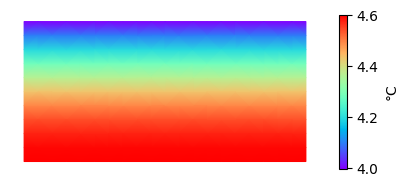

At mpc_iteration  19.5
Objective value is:  1.3709519302555923e-07


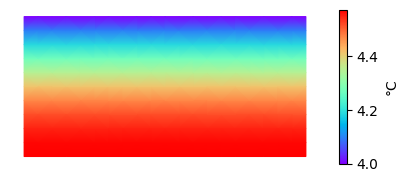

At mpc_iteration  19.75
Objective value is:  1.388694900288834e-07


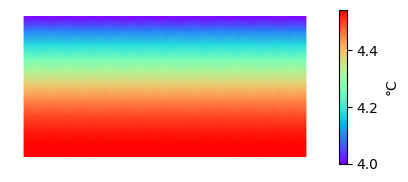

At mpc_iteration  20.0
Objective value is:  1.4062099130454976e-07


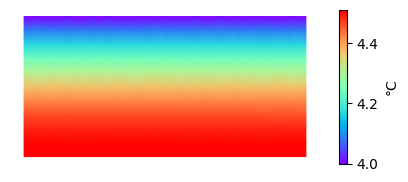

At mpc_iteration  20.25
Objective value is:  1.4235021693044842e-07


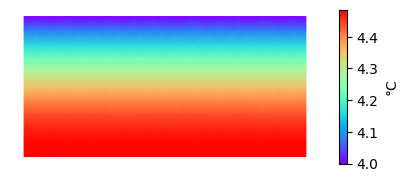

At mpc_iteration  20.5
Objective value is:  1.4405768283406735e-07


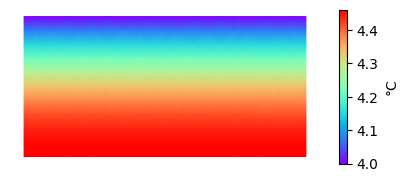

At mpc_iteration  20.75
Objective value is:  1.4574390046174494e-07


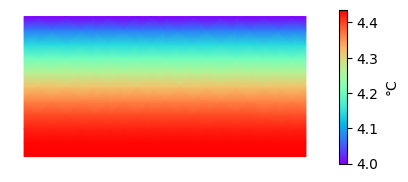

At mpc_iteration  21.0
Objective value is:  1.4741507183449405e-07


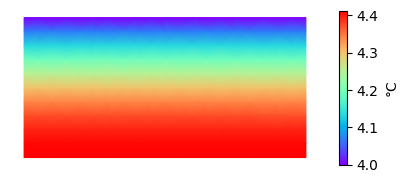

At mpc_iteration  21.25
Objective value is:  2.0763683878477482e-07


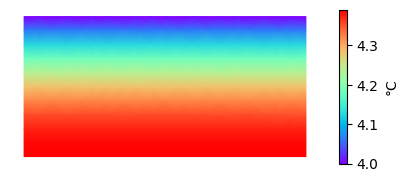

At mpc_iteration  21.5
Objective value is:  2.1473411061638794e-07


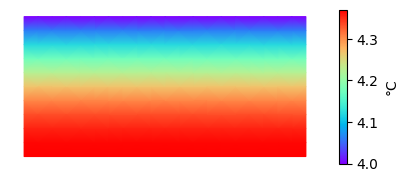

At mpc_iteration  21.75
Objective value is:  1.9567666192009573e-07


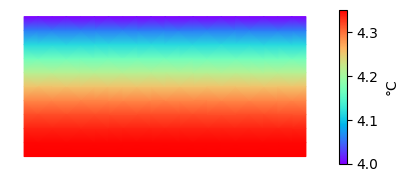

At mpc_iteration  22.0
Objective value is:  1.7635319682850433e-07


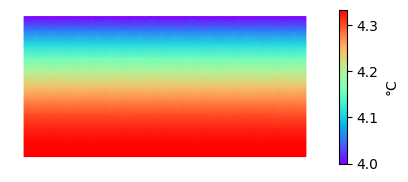

At mpc_iteration  22.25
Objective value is:  1.4443338572436445e-07


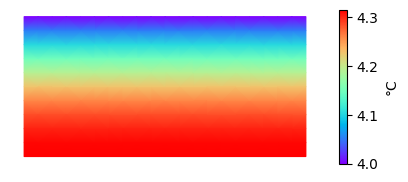

At mpc_iteration  22.5
Objective value is:  1.2484647432861859e-07


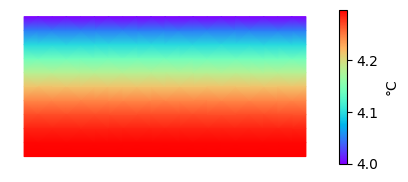

At mpc_iteration  22.75
Objective value is:  1.0152365549233275e-07


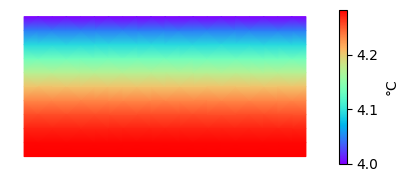

At mpc_iteration  23.0
Objective value is:  8.215921836357777e-08


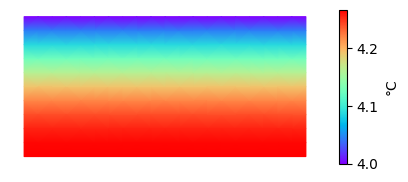

At mpc_iteration  23.25
Objective value is:  6.26914437356017e-08


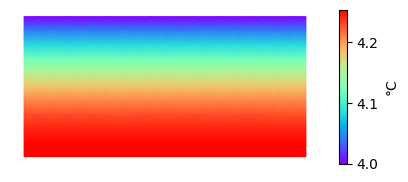

At mpc_iteration  23.5
Objective value is:  4.283405155101237e-08


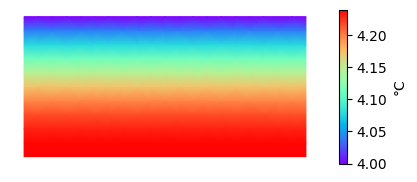

At mpc_iteration  23.75
Objective value is:  2.2093071198853446e-08


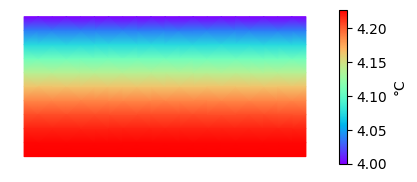

In [57]:
def Create_Model(MPC_ITER):

  time_points = [round(t, 2) for t in np.linspace(0, 24, 97)]


  m = ConcreteModel()
  m.simulation_period = Param(initialize=24)  ## in hours
  m.dt = Param(initialize=0.25)               ## time step 15 minutes
  m.time_state = Set(initialize=time_points, ordered=True)
  m.time_ctrl  = Set(initialize=time_points[:-1], ordered=True)

  m.predic_hrzn = Param(initialize=2.5)
  P = 2.5

  time_value_dict = {t: val for t, val in zip(list(m.time_state), h_is)}

  m.h_is = Param(m.time_state, initialize=time_value_dict)

  m.h_ic = Param(initialize=h_ic)

  # Parameters definition
  m.Cp = Param(initialize=1000)
  m.eta_vol = Param(initialize=0.6)
  m.rho = Param(initialize=485)
  m.vol = Param(initialize=0.75e-3)
  m.eta_istrpc = Param(initialize=0.55)
  m.cop = Param(initialize=0.45)

  # Define states and control variables
  m.Ta = Var(m.time_state)
  m.w = Var(m.time_ctrl)

  desired_temp = 4

  m.MPC_ITER = Param(initialize=MPC_ITER)

  # Declare the differential equation
  def _room_temp(model, t):
    if model.MPC_ITER + model.dt <= t <= model.MPC_ITER + model.predic_hrzn:
      return model.Cp*(model.Ta[t] - model.Ta[t - model.dt]) == -( (model.w[t - model.dt]*model.vol*model.rho*model.eta_vol*model.cop*(model.h_is[t-model.dt] - model.h_ic)*model.dt) / model.eta_istrpc )
    else:
      return Constraint.Skip
  m.room_temp_constr = Constraint(m.time_state, rule=_room_temp)

  def objective_rule(model):
      # control_effort = sum( model.u[t]**2 for t in model.time)
      # control_rate_penalty = sum((model.w[t] - model.w[t-model.dt])**2 for t in model.time_ctrl if model.MPC_ITER + model.dt < t <= model.MPC_ITER + model.predic_hrzn) # penalize change
      tracking_error = sum((model.Ta[t] - desired_temp)**2 for t in model.time_state if model.MPC_ITER + model.dt <= t <= model.MPC_ITER + model.predic_hrzn )  # temperature tracking error
      return 0.5*tracking_error    # weight the tracking error

  m.objective = Objective(rule=objective_rule, sense=minimize)

  def _ineq_constraint_ub(model, t):
    if (model.MPC_ITER <= t < model.MPC_ITER + model.predic_hrzn):
      return model.w[t] <= 70
    else:
      return Constraint.Skip
  m.ineq_constr_ub = Constraint(m.time_ctrl, rule=_ineq_constraint_ub)

  def _ineq_constraint_lb(model, t):
    if (model.MPC_ITER <= t < model.MPC_ITER + model.predic_hrzn):
      return model.w[t] >= 0
    else:
      return Constraint.Skip
  m.ineq_constr_lb = Constraint(m.time_ctrl, rule=_ineq_constraint_lb)

  return m

list_opt_ctrl = []
MPC_ITER = 0.0
current_state = 20
list_opt_state = [current_state]
list_obj_func = []

M = Create_Model(MPC_ITER)
solver = SolverFactory('ipopt', tee=False)

while (MPC_ITER <= M.time_ctrl[-1]):

  print("At mpc_iteration ",MPC_ITER)
  M = Create_Model(MPC_ITER)
  M.ic_T = Constraint(expr=M.Ta[MPC_ITER] == current_state)

  # Solve the model and update current_state for the next iteration
  results = solver.solve(M, tee=False)

  obj_val = value(M.objective)
  print("Objective value is: ", obj_val)
  list_obj_func.append(obj_val)

  opt_ctrl = value(M.w[MPC_ITER])
  list_opt_ctrl.append(opt_ctrl)

  # Print the optimized states
  MPC_ITER += M.dt.value

  # Update current_state after solving
  if results.solver.termination_condition == TerminationCondition.optimal:
      current_state = value(M.Ta[MPC_ITER])
  list_opt_state.append(current_state)

  for t in M.time_ctrl:
    if (M.MPC_ITER <= t < M.MPC_ITER + M.predic_hrzn):
      M.w[t] = value( M.w[t] )

  bc_2 = DirichletBC(W.sub(1), current_state, boundary)
  solve(a==L, u_sol, bc_2)
  T1_sol, T2_sol = u_sol.split()

  T_values = T2_sol.compute_vertex_values(mesh)
  coordinates = mesh.coordinates()

  #     Plot with Matplotlib (rainbow colormap)
  plt.figure(figsize=(5, 2))
  plt.tripcolor(coordinates[:, 0], coordinates[:, 1], T_values, shading="gouraud", cmap="rainbow")
  plt.colorbar(label="°C")
  #         plt.title("Temperature Distribution at final time ")
  plt.axis("off")  # Hide the entire axis
  plt.show()

  u_n.assign(u_sol)

In [15]:
list_time_states = list(M.time_state)
list_time_ctrl = list(M.time_ctrl)
plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.plot(list_time_states, list_opt_state)
plt.title('room temperature')
plt.subplot(122)
plt.plot(list_time_ctrl, list_opt_ctrl, "r--")
plt.title('compressor rotational speed')

In [25]:
plt.plot(list_time_ctrl, list_obj_func, 'g')
plt.title("Objective function")